# Congenital Central Hypoventilation syndrome ("Ondine syndrome") from scratch

This vignette displays some examples of what can be achieved using **NORDic** in order to identify gene regulatory networks.

## Installation

In [1]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.2.6


## A. Registration to databases used by NORDic NI

In the absence of data normally used for network inference (a prior knowledge network, a set of experiments, a set of genes of interest, ...), **NORDic** retrieves data from public databases. The registration to these databases is free (often only requires an academic e-mail address), time-unlimited, but mandatory.

### A.1. Registration to [DisGeNET](https://www.disgenet.org/signup/)

Click on the link above to sign up to DisGeNET. Once you are registered, open an empty .TXT file, and write down
- on the first line: the e-mail address used for registration
- on the second line: the chosen password
Save the file, and replace the relative path to that file in the cell below

In [2]:
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"

### A.2 Registration to STRING

The STRING database requires an identification of the person sending requests to the database. Write down on the first line of an empty .TXT file your e-mail address, and replace the relative path to that file in the cell below:

In [3]:
STRING_credentials = "../tests/credentials_STRING.txt"

### A.3 Registration to [LINCS L1000/CLUE.io](https://clue.io/lincs)

Click on the link above to sign up to CLUE.io. Once you are registered, open an empty .TXT file, and write down
- on the first line: the e-mail address used for registration
- on the second line: the chosen password
- on the third line: the user key you were assigned
Save the file, and replace the relative path to that file in the cell below

In [4]:
LINCS_credentials = "../tests/credentials_LINCS.txt"

## B. Selection of parameters

The goal of **NORDic** is to allow to infer a network in the most transparent and reproducible fashion possible. As such, it relies on a (rather large) set of parameters which control the pipeline and the processing of biological data. For the actual definition of the parameters and an overview of the pipeline, please have a look at the following [reference](https://clreda.github.io/assets/reda2022prioritization_accepted.pdf):


> Réda, C., & Delahaye-Duriez, A. (2022). Prioritization of Candidate Genes Through Boolean Networks. In *International Conference on Computational Methods in Systems Biology* (pp. 89-121). Springer, Cham.


First, define the seed number (for an increased reproducibility), along with the number of threads to allocate to the network inference process

In [5]:
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2) ## all available threads but 2

Second, define the folder to create (relative to the folder in which the present notebook is located), in which to store intermediary files and the network itself

In [6]:
file_folder="MODELS/Ondine/"

The title of this section says that we are going to infer a network *from scratch*. Meaning, the only information provided to **NORDic** is *only* the name of the disease itself (that is, its Concept ID on [NCBI MedGen](https://www.ncbi.nlm.nih.gov/medgen/)), and the species (the taxonomy ID on [NCBI Taxonomy](https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi). If we were interested in several subtypes of diseases, one could write down a list of Concept IDs.

In [7]:
taxon_id=9606 # human species
disease_cids=["C1275808"] ## Concept ID of Ondine syndrome

Optionally, in order to guide the inference of the regulatory mechanisms at play, one can define the cell types of interest (which should be present in the database [LINCS L1000](https://lincsproject.org/)). Otherwise, all cell lines in LINCS L1000 are considered.

In [8]:
cell_lines=["NPC", "SHSY5Y"] # brain cell lines in LINCS L1000

### B.1 Information about the disease

In the absence of a set of genes of interest to focus on, **NORDic** retrieves a set of disease-associated genes from the DisGeNET database

In [9]:
DISGENET_args = {
        "credentials": DisGeNET_credentials,
        "disease_cids": disease_cids,
}

### B.2 Selection of parameters relative to the prior knowledge network 

A prior knowledge network is built using protein-protein interaction networks (PPI) from the STRING database. One can set a threshold on the "combined score" provided by STRING on every edge of the PPI

In [10]:
STRING_args = {
        "credentials": STRING_credentials,
        "score": 0, # threshold on the minimum score of STRING edges
}

During inference, the edges retrieved from the STRING database might be filtered out (*filter=True*) based on the associated gene expression pairwise correlation (correlation>*tau*), preserving the connectivity of the network (i.e., having a single weakly connected component, that is, no isolated bits) (*connected=True*).

In [11]:
EDGE_args = {
        "tau": 0, # filter edges according to the genepairwise expression correlation
        "filter": True, # whether to apply the filter
        "connected": True, # whether to preserve the connectivity of the network
}

Since version 2.2.0, one can preserve nodes which are not measured by LINCS L1000 or which do not match an EntrezGene ID (which allows considering miRNA nodes, for instance). In order to do so, set the following parameter to True (to preserve the initial behavior, which is the default one, set it to False):

In [12]:
accept_nonRNA=True

Since version 2.2.3, **NORDic** may infer the sign of the edges in an *existing* prior knowledge network using the gene expression data retrieved from **LINCS L1000**, instead of using the sign of the edge-related scores in the network stored at "network_fname", by setting option *preserve_network_sign* to **False**. The default behavior is *preserve_network_sign=* **True**, and is consistent with the behavior of past versions of **NORDic**.

In [13]:
preserve_network_sign=False

### B.3 Selection of parameters relative to experimental constraints

In the absence of a set of experimental profiles, **NORDic** retrieves a set of experimental profiles from the database LINCS L1000. Note that it downloads files from LINCS L1000 (which might be large, around 73GB in total). One might also set a nonnegative threshold on the quality of experiments retrieved from LINCS L1000 (*thres_iscale*), which was introduced by

> Cheng, Lijun, and Lang Li. "Systematic quality control analysis of LINCS data." CPT: pharmacometrics & systems pharmacology 5.11 (2016): 588-598.

The threshold recommended by that paper is 0. However, if you would like not to filter any experiment out, set this value to None.

In [14]:
LINCS_args = {
        "path_to_lincs": "../lincs/", # where to store locally LINCS L1000 files
        "credentials": LINCS_credentials,
        "cell_lines": cell_lines,
        "thres_iscale": None, # threshold to filter out experiments from LINCS L1000
}

Since **NORDic** infers a Boolean network, the experimental profiles retrieved from LINCS L1000 need to be binarized; i.e., all expression values are either 0 (inactive), 1 (active), or NaN (undetermined status: neither fully inactive nor active). The control upon this binarization is made through parameter *bin_thres*, which is comprised between 0 (all genes have an undetermined status, that is, no constraint from the experiments will be enforced) and 0.5 (all genes have a binary status, which correspond to strong experimental constraints).

In [15]:
SIG_args = {
        "bin_thres": 0.5, # threshold to binarize gene expression values
}

Since version 2.2.0, NORDic can try and infer a network -without returning an error- even when no experimental data is available. In that case, there are no experimental constraints, and it boils down to choosing appropriate parameters in Section B.2 to filter out (or not) edges. In order to do so, set the following parameter to False (to preserve the initial behavior, which is the default one, set it to True):

In [16]:
force_experiments=False

### B.4 Selection of parameters relative to the inference of networks

Once **NORDic** has built the prior knowledge network, and the Boolean experimental constraints, it uses BoneSIS to infer valid solution networks. Please refer to the following paper:

> Chevalier, Stéphanie, et al. "Synthesis of boolean networks from biological dynamical constraints using answer-set programming." 2019 IEEE 31st International Conference on Tools with Artificial Intelligence (ICTAI). IEEE, 2019.

In [17]:
BONESIS_args = {
        "limit": 1, # maximum number of solution networks to infer
        "exact": True, # should any solution use ALL edges from the prior knowledge network?
        "max_maxclause": 3, # quantifies the complexity of the regulatory functions
}

### B.5 Advanced parameters

Those parameters can be ignored, as the default values usually do the trick. Please refer to the paper for more information.

In [18]:
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1} # how to select an optimal model

### B.6 Summary

All in all, let us sum up the parameter values:

In [19]:
## Registration to databases
DisGeNET_credentials = "../tests/credentials_DISGENET.txt"
STRING_credentials = "../tests/credentials_STRING.txt"
LINCS_credentials = "../tests/credentials_LINCS.txt"

## Parameters
seed_number=123456
from multiprocessing import cpu_count
njobs=max(1,cpu_count()-2) ## all available threads but 2
file_folder="MODELS/Ondine/"
taxon_id=9606 # human species
disease_cids=["C1275808"] ## Concept ID of Ondine syndrome
cell_lines=["NPC", "SHSY5Y"] # brain cell lines in LINCS L1000

## Information about the disease
DISGENET_args = {
        "credentials": DisGeNET_credentials, "disease_cids": disease_cids,
}

## Selection of parameters relative to the prior knowledge network 
STRING_args = {
        "credentials": STRING_credentials, "score": 0,
}
EDGE_args = {
        "tau": 0, "filter": True, "connected": True, 
}

accept_nonRNA=True
preserve_network_sign=True

## Selection of parameters relative to experimental constraints
LINCS_args = {
        "path_to_lincs": "../lincs/", "credentials": LINCS_credentials,
        "cell_lines": cell_lines, "thres_iscale": -1,
}
SIG_args = {
        "bin_thres": 0.5,
}

force_experiments=False

## Selection of parameters relative to the inference of networks
BONESIS_args = {
        "limit": 1, "exact": True, "max_maxclause": 3,
}

## Advanced
DESIRABILITY = {"DS": 3, "CL": 3, "Centr": 3, "GT": 1}

Don't be afraid! There is a rule of thumb to decide which parameter values to choose:
- First choose score=0 in the STRING arguments, thres_iscale=None in the LINCS arguments, tau=0 to select all possible edges in the edge-wise arguments, and bin_thres=0.5 to restrict as much as possible experiment-wise in the signature-wise arguments, max_maxclause=3 to consider more simple regulatory functions, and exact=False in the BoneSiS arguments
- If there is an explosion in RAM use (happens for a good personal computer when the number of edges fed to the Boolean network is >3,000), reduce the number of edges by playing with parameters score and tau
- If no model is found, decrease the value of parameter bin_thres in [0,0.5], or increase max_maxclause (leave it smaller than 10, otherwise the RAM goes KABOOM)
- If there are too many models, add more constraints by increasing the value of score, tau, or bin_thres, or setting exact=True (meaning that any solution should use ALL edges fed to the solver)

Moreover, as a general rule: if you prefer having a denser network at the end of the inference, decrease the value of bin_thres. On the contrary, if you prefer putting more credence on experimental contraints, bin_thres should be increased.

## C. Network inference

A single function takes these parameters, and returns a single solution network. Note that this step can be quite time-consuming depending on the number of genes and the size of the prior knowledge network (sometimes in (dozens of) hours...).

In [20]:
from NORDic.NORDic_NI.functions import network_identification
solution = network_identification(file_folder, taxon_id, 
                                  path_to_genes=None, network_fname=None,
                                  disgenet_args=DISGENET_args, 
                                  string_args=STRING_args, edge_args=EDGE_args, 
                                  lincs_args=LINCS_args, sig_args=SIG_args, 
                                  bonesis_args=BONESIS_args, 
                                  weights=DESIRABILITY, 
                                  seed=seed_number, njobs=njobs,
                                  force_experiments=force_experiments, 
                                  accept_nonRNA=accept_nonRNA, 
                                  preserve_network_sign=preserve_network_sign)

--- DATA IMPORT ---
1. Import gene set from DisGeNET... <DISGENET> Retrieving genes... 1/1
... 7 genes imported.
2. Import network from STRING... ... 15 edges in model (including 0 directed edges) with a total of 6 non-isolated genes
3. Import experiments from LINCS L1000... 
	2 cell lines are considered (['NPC', 'SHSY5Y'])
	6 genes available (convertable to EntrezIDs)
		6/6 genes retrieved in LINCS L1000
		1 unique experiments (including 1 with criterion thres_iscale > -1, min_value -0.013912489293518515)
... 6 genes in 6 profiles (1 experiments)

--- CONSTRAINT BUILDING ---
1. Filtering out edges by minimum set of edges with highest score which preserve connectivity... ... 15 unique edges involving genes both in experiments (6 genes in total)
... score_STRING 0.000000	6 genes (non isolated in PPI)	60 edges in PPI
2. Build topological constraints from filtered edges using gene expression data...  ...... 14 negative, 16 positive undirected interactions (30 edges in total), 6 non isolat

  0%|                                                                                | 0/1 [00:00<?, ?it/s]

Grounding...done in 0.0s
Found 1 solutions in 0.0s (first in 0.0s; rate 0.0s)

100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.44it/s]

--- SELECTION OF OPTIMAL MODEL ---
A. Select an optimal model based on a topological criteria...  ...1 solutions (1 unique solutions)
... 1 solutions (0/7 constant genes in average)
<MODEL VISUALIZATION> Minimal solution: 30 edges


<MODEL VISUALIZATION> Maximal solution: 30 edges
            1
GTP  0.858009
<MODEL SELECTION> Saving optimal model in 'MODELS/Ondine//solution.bnet' ...
ASCL1, !BDNF&!EDN3&!GDNF&PHOX2B&RET
BDNF, RET|(!ASCL1&EDN3)|(!GDNF&!PHOX2B)
EDN3, !ASCL1|(BDNF&!PHOX2B)|(GDNF&RET)
GDNF, !ASCL1&!BDNF&EDN3&!PHOX2B&RET
PHOX2B, !GDNF|(ASCL1&RET)|(!BDNF&!EDN3)
...
... saved!


## D. Network visualization

If you have a look at the folder *file_folder*, you can notice that there are a lot of intermediary files, comprising an image of the inferred network *inferred_max_criterion_solution*

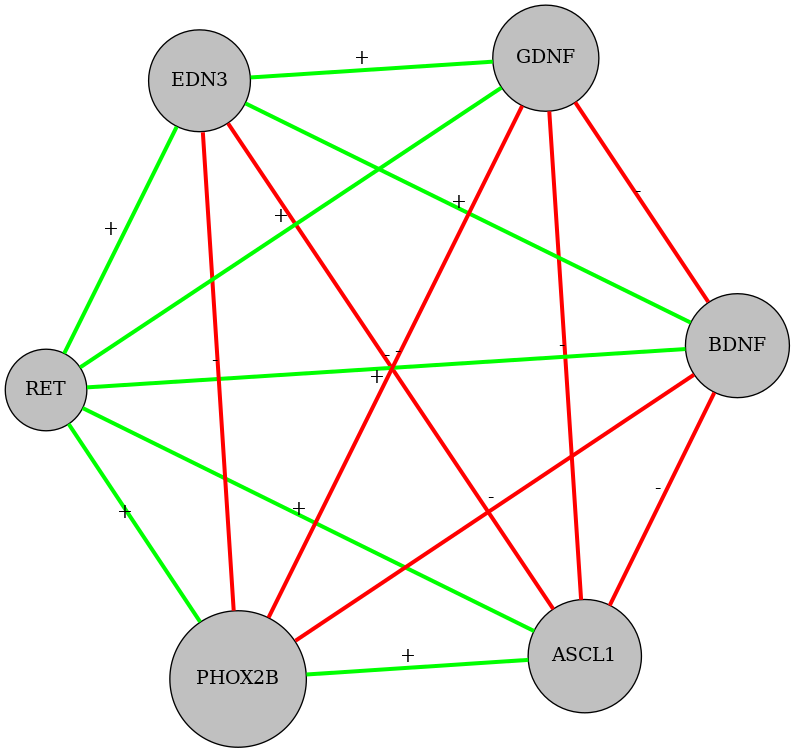

In [21]:
from IPython.display import Image
Image(filename=file_folder+'inferred_max_criterion_solution.png') 

and the .BNET file *solution.bnet* that contains the gene regulatory functions defining the dynamics of the Boolean network 

In [22]:
with open(file_folder+"solution.bnet", "r") as f:
    network = f.read()
print(network)

ASCL1, !BDNF&!EDN3&!GDNF&PHOX2B&RET
BDNF, RET|(!ASCL1&EDN3)|(!GDNF&!PHOX2B)
EDN3, !ASCL1|(BDNF&!PHOX2B)|(GDNF&RET)
GDNF, !ASCL1&!BDNF&EDN3&!PHOX2B&RET
PHOX2B, !GDNF|(ASCL1&RET)|(!BDNF&!EDN3)
RET, GDNF|(ASCL1&BDNF)|(EDN3&PHOX2B)


If needed, you can convert this network into network (at *file_folder*/solution_cytoscape.sif) and style (at *file_folder*/solution_cytoscape.xml) files readable by [Cytoscape](https://cytoscape.org/)

In [23]:
from NORDic.NORDic_NI.functions import solution2cytoscape
from NORDic.UTILS.utils_grn import load_grn
solution = load_grn(file_folder+"solution.bnet")
solution2cytoscape(solution, file_folder+"solution_cytoscape")

### E. Conclusion

The previous network might not be very interesting, due to the small number of genes. **NORDic** allows feeding an existing network (cf. notebook **NORDic NI Part II**) or a set of genes (cf. notebook **NORDic NI Part III**) to the network identification pipeline. Checking those notebooks is in no way mandatory, but allows to go further on the use of **NORDic**.